<a href="https://colab.research.google.com/github/Nirzaree/DSND_Term2/blob/master/LULC_Bangalore_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import ee

In [ ]:
ee.Authenticate()

True

In [ ]:
ee.Initialize(project='ee-nirzareephotos')

### Download boundary

In [ ]:
ISO = 'IND'
ADM = 'ADM2'
RELEASE_TYPE = 'gbOpen'

In [ ]:
import requests

In [ ]:
# Query geoBoundaries
r = requests.get('https://www.geoboundaries.org/api/current/{}/{}/{}/'.format(RELEASE_TYPE,ISO,ADM))


In [ ]:
dl_path = r.json()['gjDownloadURL']

In [ ]:
filename = 'geoboundary.geojson'
geoboundary = requests.get(dl_path).json()

In [ ]:
# !pip install geojson

In [ ]:
import geojson

In [ ]:
with open(filename,'w') as file:
  geojson.dump(geoboundary,file)

In [ ]:
import geopandas as gpd

In [ ]:
geoboundary = gpd.read_file(filename)

In [ ]:
geoboundary.shape

(735, 6)

In [ ]:
geoboundary.head()

shapeName shapeISO                  shapeID shapeGroup shapeType  \
0   Ashoknagar           76128533B75548370501185        IND      ADM2   
1       Raisen           76128533B57893545331548        IND      ADM2   
2   Chhindwara           76128533B70646408240587        IND      ADM2   
3        Betul           76128533B82559220423608        IND      ADM2   
4  Hoshangabad           76128533B45314020251888        IND      ADM2   

                                            geometry  
0  POLYGON ((78.17491 24.84254, 78.17466 24.84194...  
1  POLYGON ((77.38167 23.07004, 77.38094 23.0698,...  
2  POLYGON ((79.23988 22.79135, 79.24 22.79172, 7...  
3  POLYGON ((78.27229 22.39973, 78.27169 22.39897...  
4  POLYGON ((78.03027 22.79953, 78.02986 22.79969...

In [ ]:
geoboundary[geoboundary['shapeName'].str.contains('Bangalore')]

shapeName shapeISO                  shapeID shapeGroup shapeType  \
441  Bangalore Rural           76128533B48075109668277        IND      ADM2   
445        Bangalore           76128533B76927648517269        IND      ADM2   

                                              geometry  
441  POLYGON ((77.38765 13.50108, 77.38628 13.49903...  
445  POLYGON ((77.32755 12.9958, 77.3279 12.99478, ...

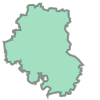

In [ ]:
geoboundary[geoboundary['shapeName'] == 'Bangalore'].iloc[0]['geometry']

### Generate Sentinel2 satellite images

In [ ]:
def generate_image(
    region,
    product='COPERNICUS/S2_SR',
    min_date='2023-01-01',
    max_date='2024-01-01',
    range_min=0,
    range_max=2000,
    cloud_pct=10
):

    """Generates cloud-filtered, median-aggregated
    Sentinel-2 image from Google Earth Engine using the
    Pythin Earth Engine API.

    Args:
      region (ee.Geometry): The geometry of the area of interest to filter to.
      product (str): Earth Engine asset ID
        You can find the full list of ImageCollection IDs
        at https://developers.google.com/earth-engine/datasets
      min_date (str): Minimum date to acquire collection of satellite images
      max_date (str): Maximum date to acquire collection of satellite images
      range_min (int): Minimum value for visalization range
      range_max (int): Maximum value for visualization range
      cloud_pct (float): The cloud cover percent to filter by (default 10)

    Returns:
      ee.image.Image: Generated Sentinel-2 image clipped to the region of interest
    """

    # Generate median aggregated composite
    image = ee.ImageCollection(product)\
        .filterBounds(region)\
        .filterDate(str(min_date), str(max_date))\
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud_pct))\
        .median()

    # Get RGB bands
    image = image.visualize(bands=['B4', 'B3', 'B2'], min=range_min, max=range_max)
    # Note that the max value of the RGB bands is set to 65535
    # because the bands of Sentinel-2 are 16-bit integers
    # with a full numerical range of [0, 65535] (max is 2^16 - 1);
    # however, the actual values are much smaller than the max value.
    # Source: https://stackoverflow.com/a/63912278/4777141

    return image.clip(region)

In [ ]:
shape_name = 'Bangalore'

In [ ]:
# !pip install eeconvert

In [ ]:
import eeconvert as eec

In [ ]:
# Get the shape geometry for Bangalore
region  = geoboundary.loc[geoboundary.shapeName == shape_name]
centroid = region.iloc[0].geometry.centroid.coords[0]
region = eec.gdfToFc(region) #geodataframe to feature collection


In [ ]:
# Generate RGB image using GEE
image = generate_image(
    region,
    product='COPERNICUS/S2', # Sentinel-2A
    min_date='2024-01-01', # Get all images within
    max_date='2024-10-01', # the year 2021
    cloud_pct=10, # Filter out images with cloud cover >= 10.0%
)

In [ ]:
import geemap.core as geemap

In [ ]:
# Visualize map
Map = geemap.Map(center=[centroid[1], centroid[0]], zoom=10)
Map.addLayer(image, {}, 'Sentinel2')
# Map.addLayerControl()
Map

Map(center=[12.949137851340922, 77.58283692401933], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [ ]:
def export_image(image, filename, region, folder):
    """Export Image to Google Drive.

    Args:
      image (ee.image.Image): Generated Sentinel-2 image
      filename (str): Name of image, without the file extension
      geometry (ee.geometry.Geometry): The geometry of the area of
        interest to filter to.
      folder (str): The destination folder in your Google Drive.

    Returns:
      ee.batch.Task: A task instance
    """

    print('Exporting to {}.tif ...'.format(filename))

    task = ee.batch.Export.image.toDrive(
      image=image,
      driveFolder=folder,
      scale=10,
      region=region.geometry(),
      description=filename,
      fileFormat='GeoTIFF',
      crs='EPSG:4326',
      maxPixels=900000000
    )
    task.start()

    return task

In [ ]:
folder = '/content/drive/MyDrive/CCAI 2024 Tutorials/2_automate_LULC_in_python/' # Change this to your file destination folder in Google drive
task = export_image(image, shape_name, region, folder)

Exporting to Bangalore.tif ...


In [ ]:
task.status()

{'state': 'COMPLETED',
 'description': 'Bangalore',
 'priority': 100,
 'creation_timestamp_ms': 1728473334272,
 'update_timestamp_ms': 1728473710265,
 'start_timestamp_ms': 1728473339131,
 'task_type': 'EXPORT_IMAGE',
 'destination_uris': ['https://drive.google.com/#folders/1H5b-u6k44IBVyshZK2wAuN73vD0kwjeR'],
 'attempt': 1,
 'batch_eecu_usage_seconds': 1132.733154296875,
 'id': 'AJ5AM2RPP4DLR2HC2V4ZKLPF',
 'name': 'projects/ee-nirzareephotos/operations/AJ5AM2RPP4DLR2HC2V4ZKLPF'}

In [ ]:
# !pip install rasterio

In [ ]:
import rasterio as rio
import matplotlib.pyplot as plt
from rasterio.plot import show

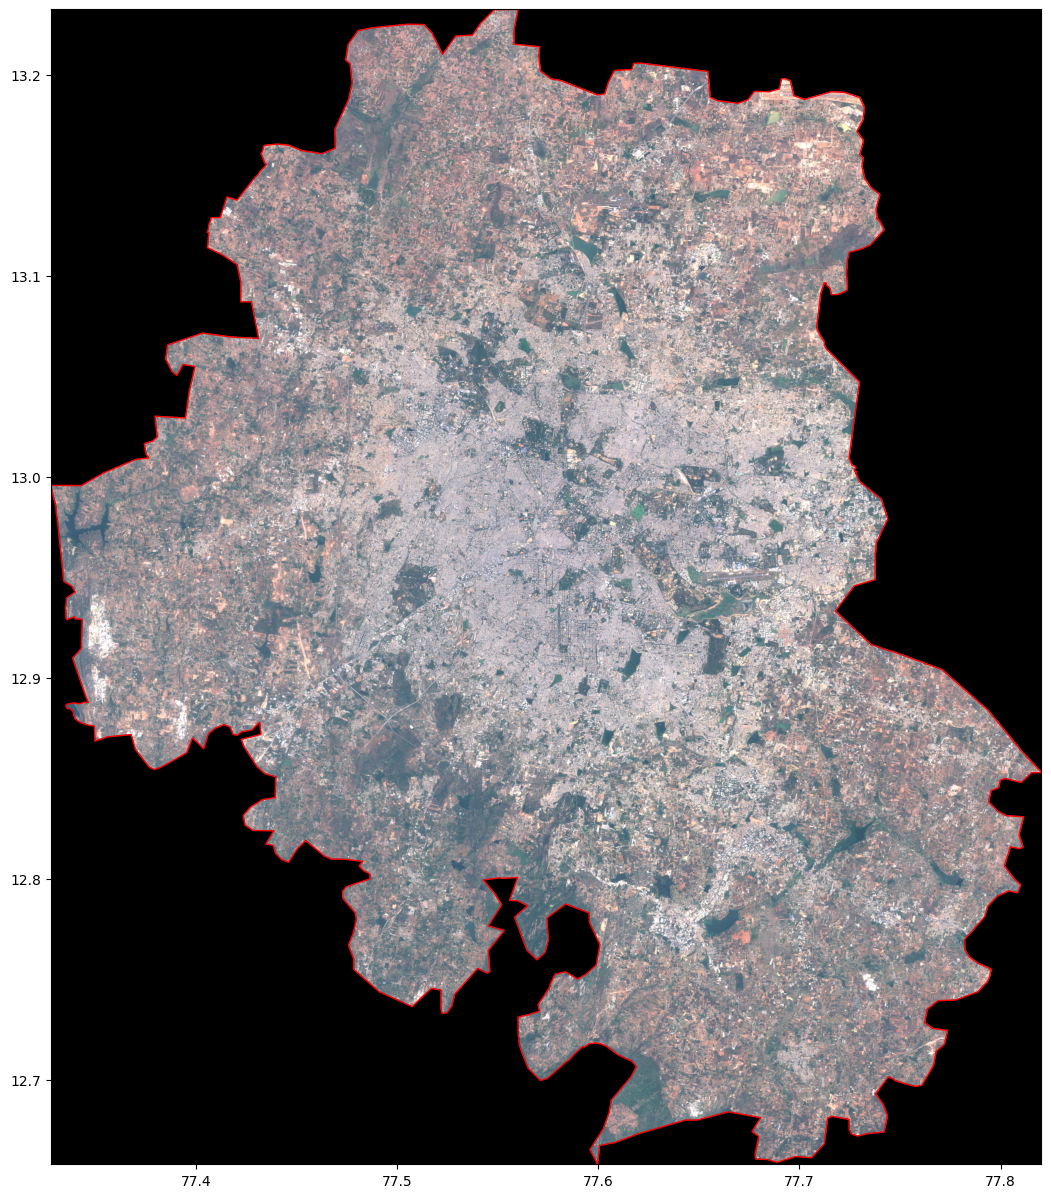

In [ ]:
# Change this to your image file path
cwd = folder
tif_file = cwd + '{}.tif'.format(shape_name)

# Open image file using Rasterio
image = rio.open(tif_file)
boundary = geoboundary[geoboundary.shapeName == shape_name]

# Plot image and corresponding boundary
fig, ax = plt.subplots(figsize=(15,15))
boundary.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);

### Generate 64 x 64 patches/tiles

In [ ]:
from tqdm import tqdm
import pandas as pd
from shapely.geometry import box

In [ ]:
def generate_tiles(image_file, output_file, area_str, size=64):
    """Generates 64 x 64 polygon tiles.

    Args:
      image_file (str): Image file path (.tif)
      output_file (str): Output file path (.geojson)
      area_str (str): Name of the region
      size(int): Window size

    Returns:
      GeoPandas DataFrame: Contains 64 x 64 polygon tiles
    """

    # Open the raster image using rasterio
    raster = rio.open(image_file)
    width, height = raster.shape

    # Create a dictionary which will contain our 64 x 64 px polygon tiles
    # Later we'll convert this dict into a GeoPandas DataFrame.
    geo_dict = { 'id' : [], 'geometry' : []}
    index = 0

    # Do a sliding window across the raster image
    with tqdm(total=width*height) as pbar:
      for w in range(0, width, size):
          for h in range(0, height, size):
              # Create a Window of your desired size
              window = rio.windows.Window(h, w, size, size)
              # Get the georeferenced window bounds
              bbox = rio.windows.bounds(window, raster.transform)
              # Create a shapely geometry from the bounding box
              bbox = box(*bbox)

              # Create a unique id for each geometry
              uid = '{}-{}'.format(area_str.lower().replace(' ', '_'), index)

              # Update dictionary
              geo_dict['id'].append(uid)
              geo_dict['geometry'].append(bbox)

              index += 1
              pbar.update(size*size)

    # Cast dictionary as a GeoPandas DataFrame
    results = gpd.GeoDataFrame(pd.DataFrame(geo_dict))
    # Set CRS to EPSG:4326
    results.crs = {'init' :'epsg:4326'}
    # Save file as GeoJSON
    results.to_file(output_file, driver="GeoJSON")

    raster.close()
    return results

In [ ]:
output_file = cwd+'{}.geojson'.format(shape_name)
tiles = generate_tiles(tif_file, output_file, shape_name, size=64)
print('Data dimensions: {}'.format(tiles.shape))
tiles.head(3)

35225600it [00:00, 80767863.05it/s]                              
/usr/local/lib/python3.10/dist-packages/pyproj/crs/crs.py:143: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Data dimensions: (8600, 2)


id                                           geometry
0  bangalore-0  POLYGON ((77.33327 13.22688, 77.33327 13.23263...
1  bangalore-1  POLYGON ((77.33902 13.22688, 77.33902 13.23263...
2  bangalore-2  POLYGON ((77.34477 13.22688, 77.34477 13.23263...

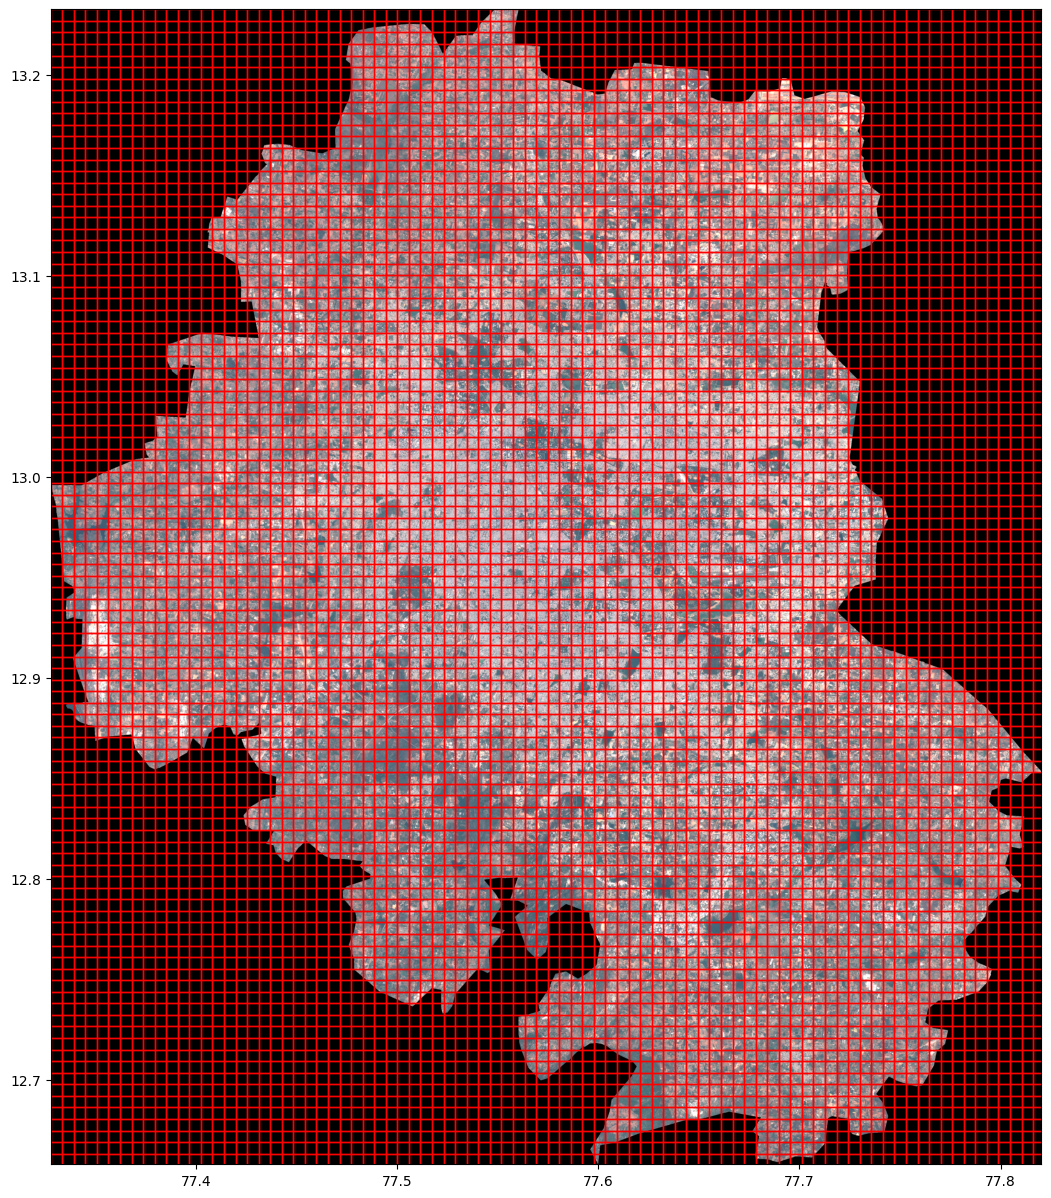

In [ ]:
image = rio.open(tif_file)
fig, ax = plt.subplots(figsize=(15,15))
tiles.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);

<ipython-input-106-f42ffb8fa7af>:4: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  tiles = gpd.sjoin(tiles, boundary,how = 'inner')


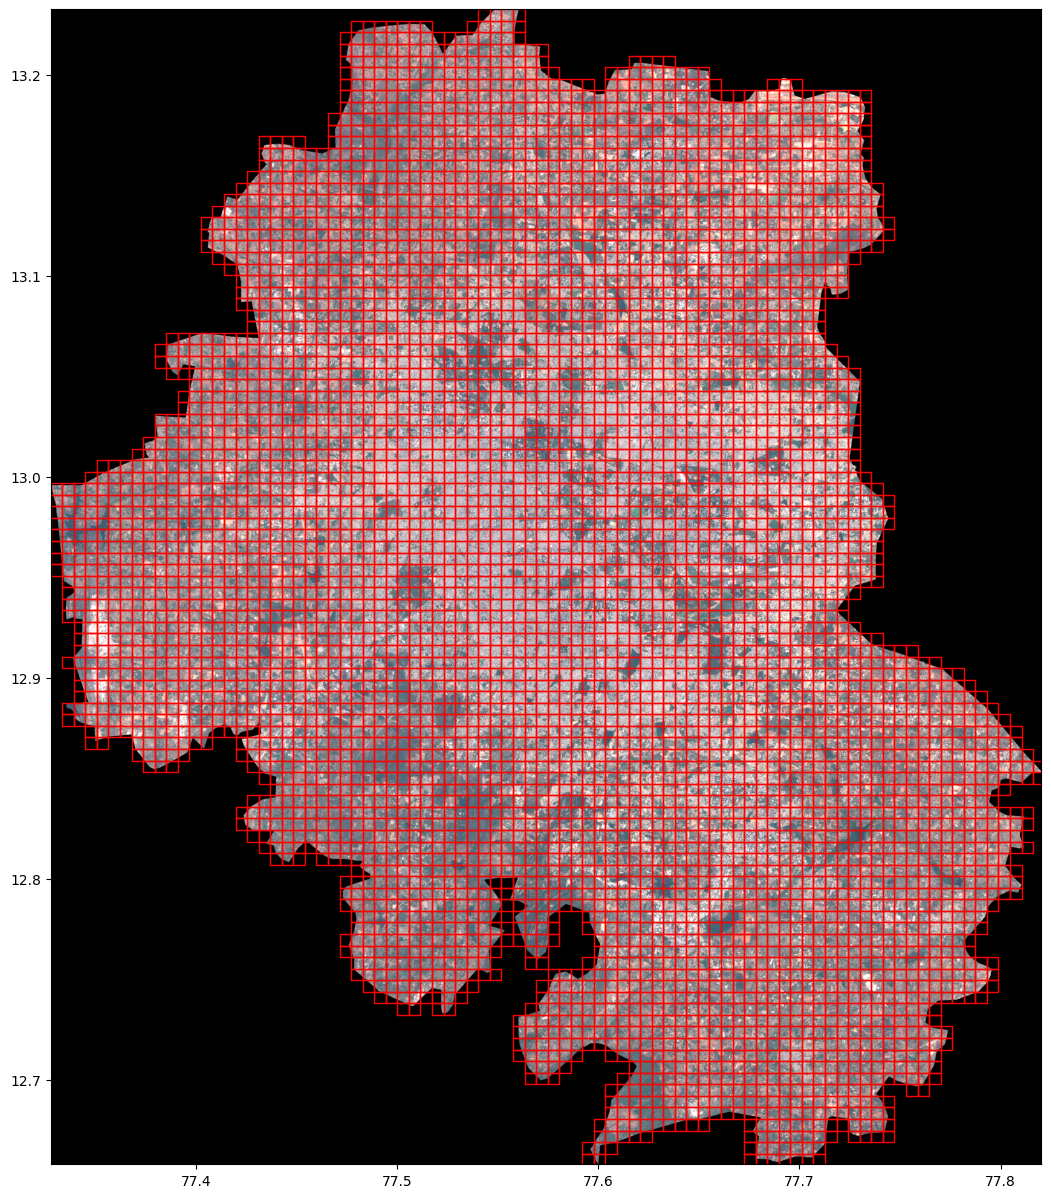

In [106]:
image = rio.open(tif_file)

# Geopandas sjoin function
tiles = gpd.sjoin(tiles, boundary,how = 'inner')

fig, ax = plt.subplots(figsize=(15,15))
tiles.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);